# Correlations between SOI and SLP, Temperature and Precipitation

- Read gridded sea level pressure from the 20th Century Reanalysis 
- use proxy grid points near Tahiti and Darwin to construct an SOI time series spanning 1950-2018
- perform lag-0 correlations between
 - SOI and SLP
 - SOI and temperature
 - SOI and preciptation using GPCP data which spans 1979-2018.
 
 In addtion, the significane level of **(p<0.01)** was dotted on the correlation maps.  **(99% significant)**

> Statistics is a branch of Mathematics. It deals with gathering, presenting, analyzing, organizing and interpreting the data, which is usually numerical. It is applied to many industrial, **scientific**, social and economic areas. While a researcher performs research, a hypothesis has to be set, which is known as the null hypothesis. This hypothesis is required to be tested via pre-defined statistical examinations. This process is termed as statistical hypothesis testing. The level of significance or Statistical significance is an important terminology that is quite commonly used in Statistics.

# Statistics
- Chi-Square Test
- Probability
- Sampling Methods
# What is Statistical Significance?
> In Statistics, **“significance” means “not by chance” or “probably true”**. We can say that if a statistician declares that some result is “highly significant”, then he indicates by stating that it might be very probably true. It does not mean that the result is highly significant, but it suggests that it is highly probable.

# Level of Significance Definition
The level of significance is defined as the fixed probability of wrong elimination of null hypothesis when in fact, it is true. The level of significance is stated to be the probability of type I error and is preset by the researcher with the outcomes of error. The level of significance is the measurement of the statistical significance. It defines whether the null hypothesis is assumed to be accepted or rejected. It is expected to identify if the result is statistically significant for the null hypothesis to be false or rejected.

# Level of Significance Symbol
The level of significance is denoted by the Greek symbol α (alpha). Therefore, the level of significance is defined as follows:

- Significance Level = p (type I error) = α

- The values or the observations are less likely when they are farther than the mean. The results are written as “significant at x%”.

> Example: The value significant at 5% refers to p-value is less than 0.05 or p < 0.05. Similarly, significant at the 1% means that the p-value is less than 0.01.

- The level of significance is taken at 0.05 or 5%. When the p-value is low, it means that the recognised values are significantly different from the population value that was hypothesised in the beginning. The p-value is said to be more significant if it is as low as possible. Also, the result would be highly significant if the p-value is very less. But, most generally, p-values smaller than 0.05 are known as significant, since getting a p-value less than 0.05 is quite a less practice.

# How to Find the Level of Significance?
To measure the level of statistical significance of the result, the investigator first needs to calculate the p-value. It defines the probability of identifying an effect which provides that the null hypothesis is true. When the p-value is less than the level of significance (α), the null hypothesis is rejected. If the p-value so observed is not less than the significance level α, then theoretically null hypothesis is accepted. But practically, we often increase the size of the sample size and check if we reach the significance level. The general interpretation of the p-value based upon the level of significance of 10%:
# (95% significance)
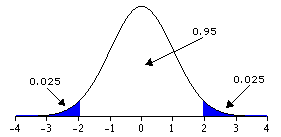 

- If p > 0.1, then there will be no assumption for the null hypothesis
- If p > 0.05 and p ≤ 0.1, it means that there will be a low assumption for the null hypothesis.
- If p > 0.01 and p ≤ 0.05, then there must be a strong assumption about the null hypothesis.
- If p ≤ 0.01, then a very strong assumption about the null hypothesis is indicated.
# Level of Significance Example
> If we obtain a p-value equal to 0.03, then it indicates that there are just 3% chances of getting a difference larger than that in our research, given that the null hypothesis exists. Now, we need to determine if this result is statistically significant enough.

> We know that if the chances are 5% or less than that, then the null hypothesis is true, and we will tend to reject the null hypothesis and accept the alternative hypothesis. Here, in this case, the chances are 0.03, i.e. 3% (less than 5%), which eventually means that we will eliminate our null hypothesis and will accept an alternative hypothesis.



In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import pandas as pd
from numba import jit
from functools import partial
from scipy.stats import pearsonr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set some parameters to apply to all plots. These can be overridden
import matplotlib
# Plot size to 12" x 7"
matplotlib.rc('figure', figsize = (15, 7))
# Font size to 14
matplotlib.rc('font', size = 14)
# Do not display top and right frame lines
matplotlib.rc('axes.spines', top = True, right = True)
# Remove grid lines
matplotlib.rc('axes', grid = False)
# Set backgound color to white
matplotlib.rc('axes', facecolor = 'white')

## 1. Basic information

***Data files***

All of these data are publicly available from the following links [NCEP/NCAR Reanalysis 1](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html) and [GPCP Version 2.3 Combined Precipitation Data Set](https://www.esrl.noaa.gov/psd/data/gridded/data.gpcp.html)

In [3]:
filslp = "slp.mon.mean.nc"
filtmp = "air.mon.mean.nc"
filprc = "Downloads/precip.mon.mean.nc"

In [4]:
filslp

'C:/Users/Prithviraj/Downloads/slp.mon.mean.nc'

***Specification for reference years***

In [5]:
yrStrt  = 1950          # manually specify for convenience
yrLast  = 2018          # 20th century ends 2018  

clStrt  = 1950          # reference climatology for SOI
clLast  = 1979          

yrStrtP = 1979          # 1st year GPCP
yrLastP = yrLast        # match 20th century

***Grid points near Tahiti and Darwin***

These two points are used to construct an SOI time series spanning 1950-2018.

In [6]:
latT = -17.6         # Tahiti
lonT = 210.75  
latD = -12.5         # Darwin 
lonD = 130.83  

## 2. Calculate SOI Index

In [7]:
# read slp data
ds_slp = xr.open_dataset(filslp).sel(time=slice(str(yrStrt)+'-01-01', str(yrLast)+'-12-31'))

# select grids of T and D
T    = ds_slp.sel(lat=latT, lon=lonT, method='nearest')
D    = ds_slp.sel(lat=latD, lon=lonD, method='nearest')

# monthly reference climatologies
TClm = T.sel(time=slice(str(clStrt)+'-01-01', str(clLast)+'-12-31'))     
DClm = D.sel(time=slice(str(clStrt)+'-01-01', str(clLast)+'-12-31'))

# anomalies reference clim
TAnom = T.groupby('time.month') - TClm.groupby('time.month').mean('time')
DAnom = D.groupby('time.month') - DClm.groupby('time.month').mean('time')

# stddev of anomalies over clStrt & clLast
TAnomStd   = np.std(TAnom.sel(time=slice(str(clStrt)+'-01-01', str(clLast)+'-12-31'))) 
DAnomStd   = np.std(DAnom.sel(time=slice(str(clStrt)+'-01-01', str(clLast)+'-12-31')))

# signal and noise
soi_signal = ((TAnom/TAnomStd) - (DAnom/DAnomStd)).rename({'slp':'SOI'}) 

In [8]:
soi_signal

<xarray.Dataset>
Dimensions:  (time: 828)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SOI      (time) float64 1.801 3.696 3.783 2.262 ... 0.3077 -0.1151 2.093

## 3. lag-0 correlation

At present, I have not found a good way to return multiple xarray.dataarray from xarray.apply_ufunc(). 

Therefore, I have to calculate Pearson correlation twice, which waste half a time.

### 3.1 Functions to calculate Pearson correlation

In [9]:
@jit(nogil=True)
def pr_cor_corr(x, y):
    """
    Uses the scipy stats module to calculate a pearson correlation test
    :x vector: Input pixel vector to run tests on
    :y vector: The date input vector 
    """
    # Check NA values
    co = np.count_nonzero(~np.isnan(x))
    if co < len(y): # If fewer than length of y observations return np.nan
        print('I am here')
        return np.nan, np.nan   
    
    corr, _ = pearsonr(x, y)
    return corr

@jit(nogil=True)
def pr_cor_pval(x, y):
    """
    Uses the scipy stats module to calculate a pearson correlation test
    :x vector: Input pixel vector to run tests on
    :y vector: The date input vector 
    """
    # Check NA values
    co = np.count_nonzero(~np.isnan(x))
    if co < len(y): # If fewer than length of y observations return np.nan
        return np.nan
    # Run the pearson correlation test
    _, p_value = pearsonr(x, y)
    return p_value   

# The function we are going to use for applying our pearson test per pixel
def pearsonr_corr(x, y, func=pr_cor_corr, dim='time'):
    # x = Pixel value, y = a vector containing the date, dim == dimension
    return xr.apply_ufunc(
        func, x , y,
        input_core_dims=[[dim], [dim]],        
        vectorize=True,   
        output_dtypes=[float]
    )

### 3.2 Calculate lag-0 correlation between SOI and (slp, temperature, precipitation), respectively

In [10]:
ds_tmp  = xr.open_dataset(filtmp).sel(time=slice(str(yrStrt)+'-01-01', str(yrLast)+'-12-31'))
ds_prc   = xr.open_dataset(filprc).sel(time=slice(str(yrStrtP)+'-01-01', str(yrLastP)+'-12-31'))

# slp
da_slp   = ds_slp.slp.stack(point=('lat', 'lon')).groupby('point')
slp_corr = pearsonr_corr(da_slp, soi_signal.SOI).unstack('point')
slp_pval = pearsonr_corr(da_slp, soi_signal.SOI, func= pr_cor_pval).unstack('point')

# tmp
da_tmp   = ds_tmp.air.stack(point=('lat', 'lon')).groupby('point')
tmp_corr = pearsonr_corr(da_tmp, soi_signal.SOI).unstack('point')
tmp_pval = pearsonr_corr(da_tmp, soi_signal.SOI, func= pr_cor_pval).unstack('point')

# prc
soi_prc  = soi_signal.sel(time=slice(str(yrStrtP)+'-01-01', str(yrLastP)+'-12-31'))
da_prc   = ds_prc.precip.stack(point=('lat', 'lon')).groupby('point')
prc_corr = pearsonr_corr(da_prc, soi_prc.SOI).unstack('point')
prc_pval = pearsonr_corr(da_prc, soi_prc.SOI, func= pr_cor_pval).unstack('point')

## 4. Visualization

### 4.1 SOI

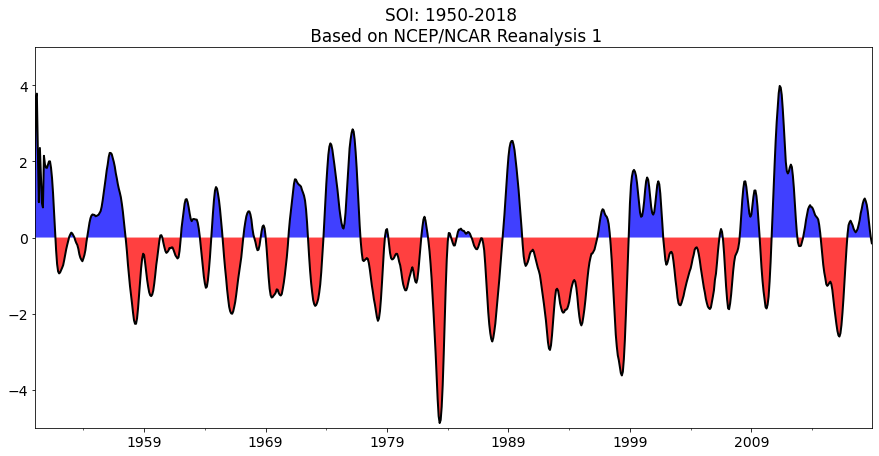

In [11]:
#plot SOI
# Convert to pandas.dataframe
df_soi = soi_signal.to_dataframe().drop('month', axis=1)

# 11-point smoother: Use reflective boundaries to fill out plot 
window  = 11
weights = [0.0270, 0.05856, 0.09030, 0.11742, 0.13567, 
           0.1421, 0.13567, 0.11742, 0.09030, 0.05856, 
           0.027]
ewma = partial(np.average, weights=weights)
rave = df_soi.rolling(window).apply(ewma).fillna(df_soi)

fig, ax = plt.subplots()
rave.plot(ax=ax, color='black', alpha=1.00, linewidth=2, legend=False)
d = rave.index
ax.fill_between(d, 0, rave['SOI'],
                where=rave['SOI'] >0,
                facecolor='blue', alpha=0.75, interpolate=True)

ax.fill_between(d, 0, rave['SOI'],
                where=rave['SOI']<0,
                facecolor='red', alpha=0.75, interpolate=True)

_ = ax.set_ylim(-5, 5)
_ = ax.set_title('SOI: %s-%s \n Based on NCEP/NCAR Reanalysis 1' %(str(yrStrt), str(yrLast)))
_ = ax.set_xlabel('')

In [249]:
df_soi

### 4.2 Correlations maps

#### 4.2.1 SOI vs. SLP

***Mask correlation with pvalues***

ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
slp_corr.where(slp_pval < 0.01).plot(ax=ax, cmap='RdYlBu_r', transform=ccrs.PlateCarree())

ax.set_title('SOI SLP')
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

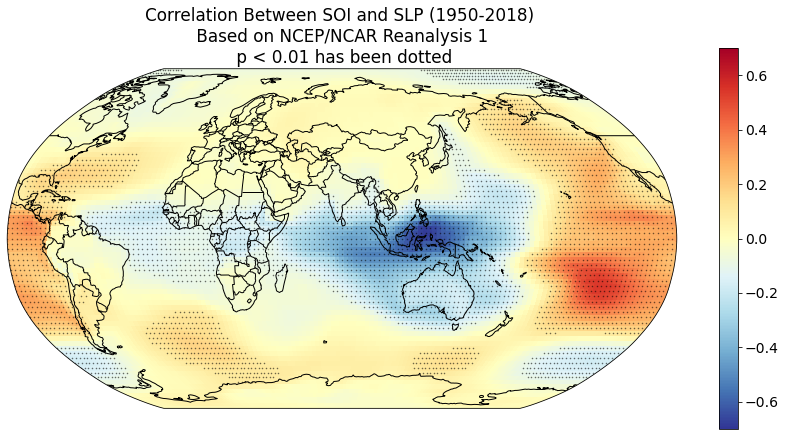

In [12]:
lons, lats = np.meshgrid(slp_corr.lon, slp_corr.lat)
sig_area   = np.where(slp_pval < 0.01)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=80))
slp_corr.plot(ax=ax, vmax=0.7, vmin=-0.7, cmap='RdYlBu_r', transform=ccrs.PlateCarree())
_ = ax.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 1, c = 'k', alpha = 0.6, transform = ccrs.PlateCarree())

ax.set_title('Correlation Between SOI and SLP (%s-%s) \n Based on NCEP/NCAR Reanalysis 1 \n p < 0.01 has been dotted' %(str(yrStrt), str(yrLast)))
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

In [250]:
#r_map=xr.corr(soi_signal,TAnomStd,dim='time')
#r_map.plot(robust=True)

#### 4.2.2 SOI vs. TMP

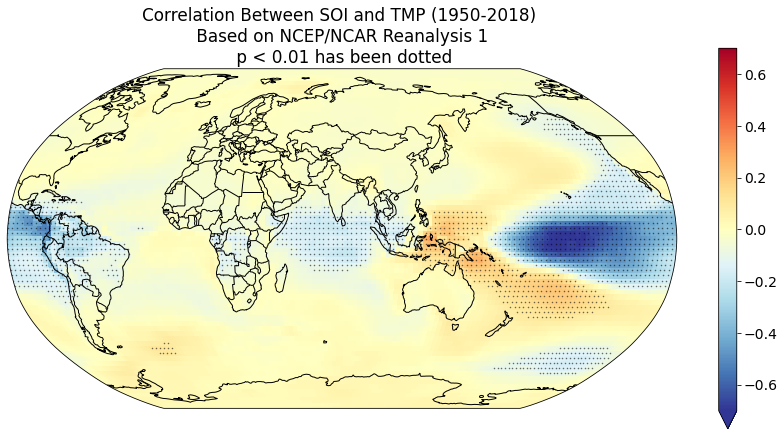

In [13]:
lons, lats = np.meshgrid(tmp_corr.lon, tmp_corr.lat)
sig_area   = np.where(tmp_pval < 0.01)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=80))
tmp_corr.plot(ax=ax, vmax=0.7, vmin=-0.7, cmap='RdYlBu_r', transform=ccrs.PlateCarree())
_ = ax.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 1, c = 'k', alpha = 0.6, transform = ccrs.PlateCarree())

ax.set_title('Correlation Between SOI and TMP (%s-%s) \n Based on NCEP/NCAR Reanalysis 1 \n p < 0.01 has been dotted' %(str(yrStrt), str(yrLast)))
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

#### 4.2.3 SOI vs. PRC

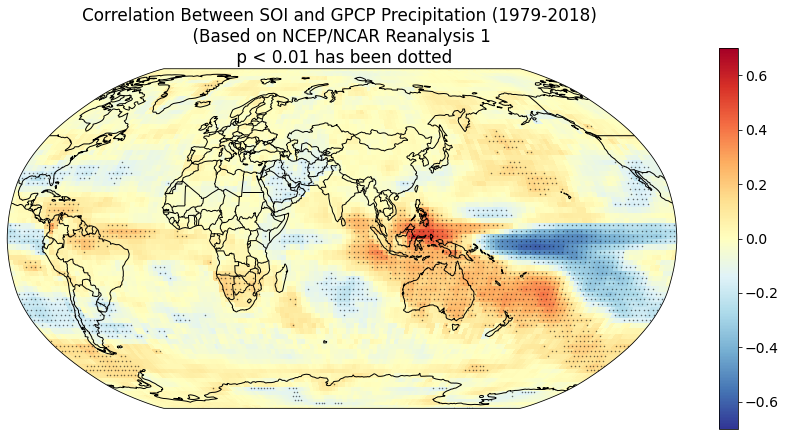

In [14]:
lons, lats = np.meshgrid(prc_corr.lon, prc_corr.lat)
sig_area   = np.where(prc_pval < 0.01)

ax = plt.axes(projection=ccrs.Robinson(central_longitude=80))
prc_corr.plot(ax=ax, vmax=0.7, vmin=-0.7, cmap='RdYlBu_r', transform=ccrs.PlateCarree())
_ = ax.scatter(lons[sig_area], lats[sig_area], marker = '.', s = 1, c = 'k', alpha = 0.6, transform = ccrs.PlateCarree())

ax.set_title('Correlation Between SOI and GPCP Precipitation (%s-%s) \n (Based on NCEP/NCAR Reanalysis 1 \n p < 0.01 has been dotted' %(str(yrStrtP), str(yrLastP)))
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

# MetPy




https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html#moist-thermodynamics


# Plotting
- MetPy contains two special types of meteorological plots, the Skew-T Log-P and Station plots, that more general Python plotting packages don’t support as readily. Additionally, with the goal to replace GEMPAK, MetPy’s declarative plotting interface is being actively developed, which will make plotting a simple task with straight-forward syntax, similar to GEMPAK.

# Skew-T
- The Skew-T Log-P diagram is the canonical thermodynamic diagram within meteorology. Using matplotlib, MetPy is able to readily create a Skew-T for you:

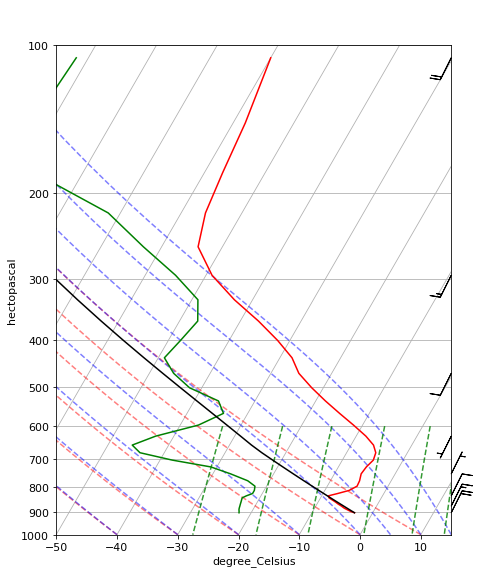

In [251]:
import matplotlib.pyplot as plt
import numpy as np
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Create arrays of pressure, temperature, dewpoint, and wind components
p = [902, 897, 893, 889, 883, 874, 866, 857, 849, 841, 833, 824, 812, 796, 776, 751,
     727, 704, 680, 656, 629, 597, 565, 533, 501, 468, 435, 401, 366, 331, 295, 258,
     220, 182, 144, 106] * units.hPa
t = [-3, -3.7, -4.1, -4.5, -5.1, -5.8, -6.5, -7.2, -7.9, -8.6, -8.9, -7.6, -6, -5.1,
     -5.2, -5.6, -5.4, -4.9, -5.2, -6.3, -8.4, -11.5, -14.9, -18.4, -21.9, -25.4,
     -28, -32, -37, -43, -49, -54, -56, -57, -58, -60] * units.degC
td = [-22, -22.1, -22.2, -22.3, -22.4, -22.5, -22.6, -22.7, -22.8, -22.9, -22.4,
      -21.6, -21.6, -21.9, -23.6, -27.1, -31, -38, -44, -46, -43, -37, -34, -36,
      -42, -46, -49, -48, -47, -49, -55, -63, -72, -88, -93, -92] * units.degC
# Calculate parcel profile
prof = mpcalc.parcel_profile(p, t[0], td[0]).to('degC')
u = np.linspace(-10, 10, len(p)) * units.knots
v = np.linspace(-20, 20, len(p)) * units.knots

skew.plot(p, t, 'r')
skew.plot(p, td, 'g')
skew.plot(p, prof, 'k')  # Plot parcel profile
skew.plot_barbs(p[::5], u[::5], v[::5])

skew.ax.set_xlim(-50, 15)
skew.ax.set_ylim(1000, 100)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()


plt.show()

# Upper air analysis is a staple of many synoptic and mesoscale analysis problems. 
- Here, we will gather weather balloon data, plot it, perform a series of thermodynamic calculations, and summarize the results. 
- To learn more about the Skew-T diagram and its use in weather analysis and forecasting, checkout this air weather service guide.

In [198]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units

In [252]:
#Getting Data
#Upper air data can be obtained using the siphon package, but for this tutorial we will use some of MetPy’s sample data. This event is the Veterans Day tornado outbreak in 2002.

col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

df = pd.read_fwf(get_test_data('nov11_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [253]:
df

,pressure,height,temperature,dewpoint,direction,speed
0,978.0,180,20.4,16.5,180.0,16.0
1,964.1,305,22.2,17.1,185.0,29.0
2,954.0,397,23.6,17.6,188.0,35.0
3,931.0,610,22.5,16.5,195.0,49.0
4,925.0,667,22.2,16.2,200.0,48.0
5,898.9,914,20.2,14.5,205.0,49.0
6,867.6,1219,17.7,12.4,215.0,52.0
7,850.0,1396,16.2,11.2,220.0,55.0
8,807.6,1829,12.7,7.7,230.0,54.0
9,804.0,1867,12.4,7.4,231.0,54.0


In [254]:
# We will pull the data out of the example dataset into individual variables and
# assign units.

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC
wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

# Thermodynamic Calculations
Often times we will want to calculate some thermodynamic parameters of a sounding. The MetPy calc module has many such calculations already implemented!

- Lifting Condensation Level (LCL) - The level at which an air parcel’s relative humidity becomes 100% when lifted along a dry adiabatic path.

- Parcel Path - Path followed by a hypothetical parcel of air, beginning at the surface temperature/pressure and rising dry adiabatically until reaching the LCL, then rising moist adiabatially.

In [255]:
# Calculate the LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

print(lcl_pressure, lcl_temperature)

# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

923.1157642313738 hectopascal 15.595751336163403 degree_Celsius


Basic Skew-T Plotting
The Skew-T (log-P) diagram is the standard way to view rawinsonde data. The y-axis is height in pressure coordinates and the x-axis is temperature. The y coordinates are plotted on a logarithmic scale and the x coordinate system is skewed. An explanation of skew-T interpretation is beyond the scope of this tutorial, but here we will plot one that can be used for analysis or publication.

The most basic skew-T can be plotted with only five lines of Python. These lines perform the following tasks:

Create a Figure object and set the size of the figure.

Create a SkewT object

Plot the pressure and temperature (note that the pressure, the independent variable, is first even though it is plotted on the y-axis).

Plot the pressure and dewpoint temperature.

Plot the wind barbs at the appropriate pressure using the u and v wind components.

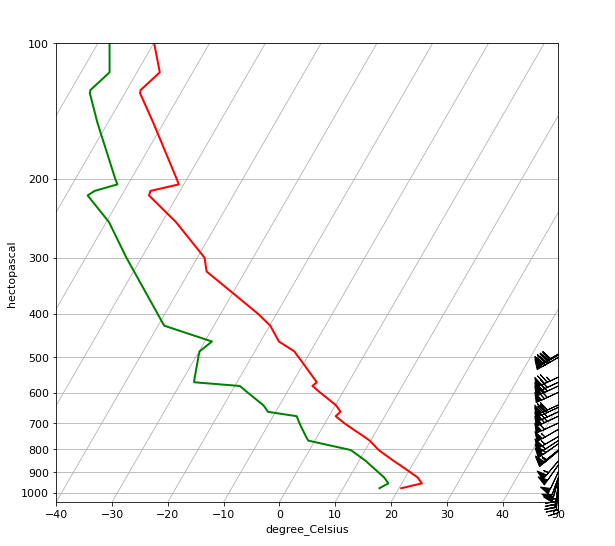

In [256]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r', linewidth=2)
skew.plot(p, Td, 'g', linewidth=2)
skew.plot_barbs(p, u, v)

# Show the plot
plt.show()

# Advanced Skew-T Plotting
Fiducial lines indicating dry adiabats, moist adiabats, and mixing ratio are useful when performing further analysis on the Skew-T diagram. Often the 0C isotherm is emphasized and areas of CAPE and CIN are shaded.

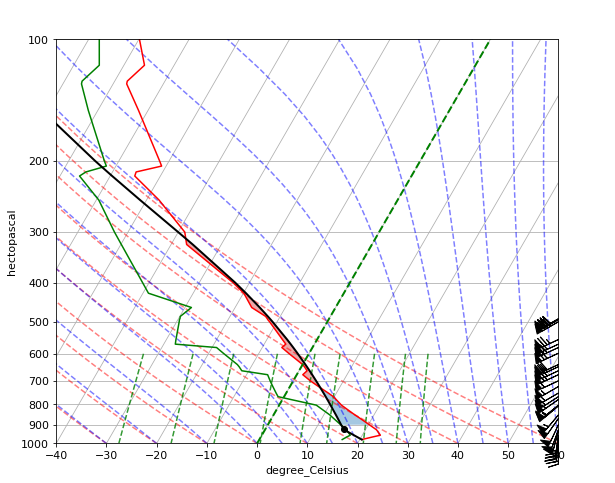

In [258]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof, Td)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='g', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

# Adding a Hodograph
- A hodograph is a polar representation of the wind profile measured by the rawinsonde. Winds at different levels are plotted as vectors with their tails at the origin, the angle from the vertical axes representing the direction, and the length representing the speed. The line plotted on the hodograph is a line connecting the tips of these vectors, which are not drawn.

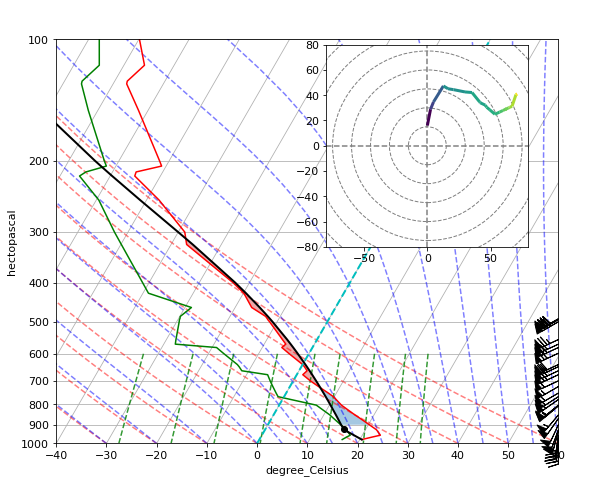

In [259]:
#a curve the radius vector of which represents in magnitude and direction the velocity of a moving object.
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof, Td)
skew.shade_cape(p, T, parcel_prof)

# Plot a zero degree isotherm
skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Create a hodograph
# Create an inset axes object that is 40% width and height of the
# figure and put it in the upper right hand corner.
ax_hod = inset_axes(skew.ax, '50%', '50%', loc=1)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=15)
h.plot_colormapped(u, v, wind_speed)  # Plot a line colored by wind speed

# Show the plot
plt.show()

# Understanding divergence, vorticity and deformation








In [260]:
import numpy as np              # Numpy is the fundamental package for scientific computing in Python.
import netCDF4 as nc            # NetCDF is the data format of the meteorological data that we use.
import matplotlib.pyplot as pl  # Matplotlib is a scientific plotting package.
from mpl_toolkits.basemap import Basemap # Import the map plotting interface.
from ipywidgets import interact
import warnings
warnings.filterwarnings('ignore')

# The statement below enforces the plots to be put into this notebook, instead of in their own windows.
%matplotlib inline
pl.rcParams.update({'font.size': 11})          # Set the standard font size of the plots to 11pt.
pl.rcParams.update({'figure.figsize': [13,6]}) # Set the standard figure size.

In [261]:
#Understanding divergence, vorticity and deformation
def plot_streamlines(div=0, zeta=0, d1=0, d2=0):
    n = 65
    x = np.linspace(-1., 1., n)
    y = np.linspace(-1., 1., n)
    u = 0.5*(div +d1)*x[np.newaxis, :] + 0.5*(d2 -zeta)*y[:,np.newaxis]
    v = 0.5*(zeta+d2)*x[np.newaxis, :] + 0.5*(div-d1  )*y[:,np.newaxis]
    U = (u**2 + v**2)**.5

    pl.figure(figsize=(6,4))
    pl.subplot(111, aspect='equal')
    pl.contourf(x, y, U, 21)
    pl.colorbar()
    pl.streamplot(x, y, u, v, color='k', arrowsize=2.)
    pl.xlabel('x')
    pl.ylabel('y')
    pl.show()
    
interact(plot_streamlines,
         div=(-1,1,0.1), zeta=(-1,1,0.1), d1=(-1,1,0.1), d2=(-1,1,0.1));

interactive(children=(FloatSlider(value=0.0, description='div', max=1.0, min=-1.0), FloatSlider(value=0.0, des…

In [263]:
#Setting up a Python Basemap and read out 3D fields
#With the code below, you initialize the world map with the desired coordinates.

# We define a map of the northern hemisphere that is stored in the m object.
lon_start =    40.
lon_end   =   180.
lat_start =    0.
lat_end   =    60.
m = Basemap(llcrnrlon=lon_start,
            llcrnrlat=lat_start,
            urcrnrlon=lon_end,
            urcrnrlat=lat_end,
            projection='mill', resolution='l')



In [264]:
#Now, you load the data and read out the desired variables from a NetCDF file from the ECMWF ERA-Interim data archive.

nc_file = nc.Dataset("era_data.nc", "r")
lat = nc_file.variables["latitude"][:]
lon = nc_file.variables["longitude"][:]
p = nc_file.variables["level"][:]*100.
t = 0
nroll = lon.size//2
lon = np.roll(lon, nroll)
lon = np.where(lon>=180., lon-360., lon)

u     = np.roll(nc_file.variables["u"][t,:,:,:], nroll, -1)
v     = np.roll(nc_file.variables["v"][t,:,:,:], nroll, -1)
omega = np.roll(nc_file.variables["w"][t,:,:,:], nroll, -1)
Phi   = np.roll(nc_file.variables["z"][t,:,:,:], nroll, -1)
T     = np.roll(nc_file.variables["t"][t,:,:,:], nroll, -1)
slp   = np.roll(nc_file.variables["msl"][t,:,:], nroll, -1)
pr    = np.roll(nc_file.variables["lsp"][t,:,:], nroll, -1)\
      + np.roll(nc_file.variables["cp" ][t,:,:], nroll, -1)

nc_file.close()

lons, lats = m(*np.meshgrid(lon, lat))
lonp, pp = np.meshgrid(lon, p)
lonrad, latrad = np.meshgrid(np.pi/180.*lon, np.pi/180.*lat)

def get_lat_index(lat_plot):
    return abs(lat-lat_plot).argmin()

def get_pressure_index(p_plot):
    return abs(p-p_plot).argmin()

nq = 3
qscale = 2000.

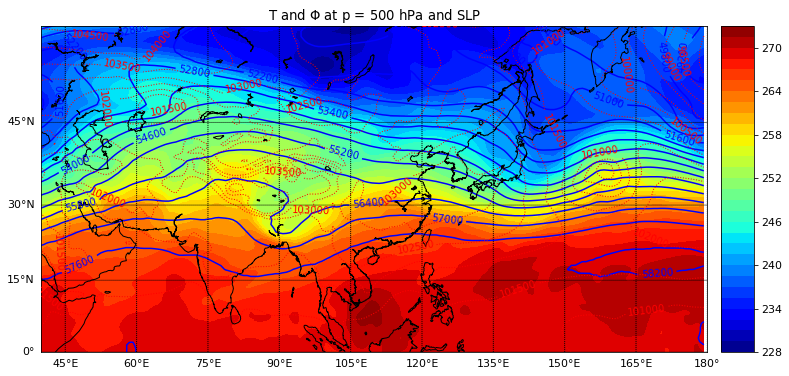

In [265]:
#Plotting the temperature, geopotential and wind vectors
#As a starting point you find below the temperature and geopotential at 500 hPa.

n = get_pressure_index(50000.)
quiver = False # Set this flag to True if you want to enable the wind arrows.

pl.figure()
m.contourf(lons, lats, T[n,:,:], 31, cmap=pl.cm.jet)
m.colorbar()
if (quiver):
    qu = m.quiver(lons[::nq,::nq], lats[::nq,::nq],
                  u[n,::nq,::nq], v[n,::nq, ::nq],
                  pivot='mid', width=1.2e-3,
                  scale=qscale)

cz = m.contour(lons, lats, Phi[n,:,:], 15, colors='b', linewidths=1.5)
pl.clabel(cz, fontsize=10., fmt='%1.0f')

cp = m.contour(lons, lats, slp, 15, colors='r', linestyles=':', linewidths=1.)
pl.clabel(cp, fontsize=10., fmt='%1.0f')

m.drawcoastlines(color='k')
# draw parallels.
parallels = np.arange(-90.,90,15.)
m.drawparallels(parallels,labels=[1,0,0,0])
# draw meridians
meridians = np.arange(0.,360.,15.)
m.drawmeridians(meridians,labels=[0,0,0,1])
pl.title('T and $\Phi$ at p = {0:.0f} hPa and SLP'.format(p[n] / 100));
#pl.tight_layout()

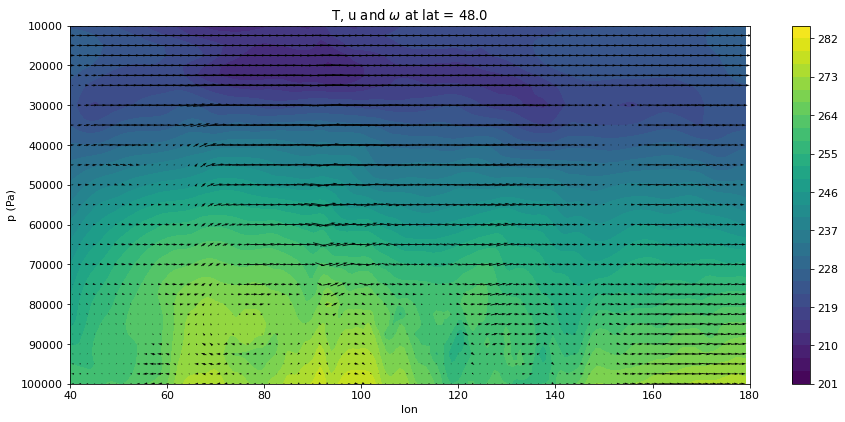

In [266]:
j_lat = get_lat_index(48.)
nqp = 2
qscalep = 1000.

pl.figure()
pl.contourf(lonp, pp, T[:,j_lat,:], 31)
pl.colorbar()
pl.quiver(lonp[:,::nqp], pp[:,::nqp],
          u[:,j_lat,::nqp], -10*omega[:,j_lat,::nqp],
          pivot='mid', width=1.2e-3,
          scale=qscalep)
pl.gca().invert_yaxis()
pl.xlim(lon_start, lon_end)
pl.ylim(100000,10000)
pl.xlabel('lon')
pl.ylabel('p (Pa)')
pl.title('T, u and $\omega$ at lat = {0}'.format(lat[j_lat]))
pl.tight_layout()

In [281]:
nc_file = xr.open_dataset("era_data.nc")
u_850=nc_file.u[:,6,:,:]
v_850=nc_file.v[:,6,:,:]
z=nc_file.z
t=nc_file.t
p=nc_file.msl
r=nc_file.q
lats = u_850.latitude
lons = v_850.longitude
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

#geop_h=mpcalc.geopotential_to_height(z)
#p_tem=mpcalc.potential_temperature(p,t)
dewpoint=mpcalc.dewpoint_from_relative_humidity(t,r)
eq_pot_temp=mpcalc.equivalent_potential_temperature(p,t,dewpoint)
m_r=mpcalc.mixing_ratio_from_specific_humidity(r)

In [277]:
p_tem

<xarray.DataArray (time: 1, latitude: 241, longitude: 480, level: 37)>
<Quantity([[[[251.27998 250.02022 252.9851  ... 223.4386  245.98012 270.40527]
   [251.27998 250.02022 252.9851  ... 223.4386  245.98012 270.40527]
   [251.27998 250.02022 252.9851  ... 223.4386  245.98012 270.40527]
   ...
   [251.27998 250.02022 252.9851  ... 223.4386  245.98012 270.40527]
   [251.27998 250.02022 252.9851  ... 223.4386  245.98012 270.40527]
   [251.27998 250.02022 252.9851  ... 223.4386  245.98012 270.40527]]

  [[252.59708 251.51884 251.64534 ... 223.37634 246.34052 269.4874 ]
   [252.60703 251.53079 251.65527 ... 223.38005 246.35243 269.48944]
   [252.6167  251.54045 251.66695 ... 223.3815  246.36606 269.49118]
   ...
   [252.56224 251.48405 251.61053 ... 223.36664 246.30188 269.4821 ]
   [252.57321 251.49701 251.62149 ... 223.37122 246.31479 269.48322]
   [252.5862  251.50798 251.63246 ... 223.37383 246.3277  269.48636]]

  [[255.47832 253.98087 254.68437 ... 223.28818 246.4494  268.77045]
   [255.56284 254.03923 254.79701 ... 223.28775 246.47348 268.77075]
   [255.64716 254.0954  254.90746 ... 223.28716 246.49535 268.77084]
   ...
...
   ...
   [267.51843 266.2592  264.91574 ... 276.91263 287.87088 294.8027 ]
   [267.5272  266.26797 264.92648 ... 276.92142 287.86768 294.80554]
   [267.5382  266.27893 264.93347 ... 276.93246 287.8647  294.80862]]

  [[267.78076 266.5053  265.22186 ... 277.10385 287.8368  294.85168]
   [267.78564 266.5102  265.2247  ... 277.10876 287.8357  294.8546 ]
   [267.7904  266.51294 265.22946 ... 277.11356 287.83447 294.85544]
   ...
   [267.767   266.49158 265.20813 ... 277.08804 287.84293 294.84576]
   [267.77167 266.49622 265.21277 ... 277.0927  287.84164 294.84848]
   [267.7762  266.50076 265.21732 ... 277.0973  287.8382  294.84906]]

  [[267.65924 266.37775 265.0481  ... 277.1593  287.88873 294.84177]
   [267.65924 266.37775 265.0481  ... 277.1593  287.88873 294.84177]
   [267.65924 266.37775 265.0481  ... 277.1593  287.88873 294.84177]
   ...
   [267.65924 266.37775 265.0481  ... 277.1593  287.88873 294.84177]
   [267.65924 266.37775 265.0481  ... 277.1593  287.88873 294.84177]
   [267.65924 266.37775 265.0481  ... 277.1593  287.88873 294.84177]]]], 'kelvin')>
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
  * time       (time) datetime64[ns] 2016-01-01T03:00:00

In [268]:
nc_file

<xarray.Dataset>
Dimensions:    (latitude: 241, level: 37, longitude: 480, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.75 358.5 359.25
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * level      (level) int32 1000 975 950 925 900 875 850 ... 20 10 7 5 3 2 1
  * time       (time) datetime64[ns] 2016-01-01T03:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 -767.0625 ... 49422...
    t          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    cp         (time, latitude, longitude) float32 ...
    lsp        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:                CF-1.6
    history:                    Sat Nov 12 16:31:59 2016: ncks -A era_data_2_...
    history_of_appended_files:  Sat Nov 12 16:31:59 2016: Appended file era_d...
    NCO:                        "4.6.1"

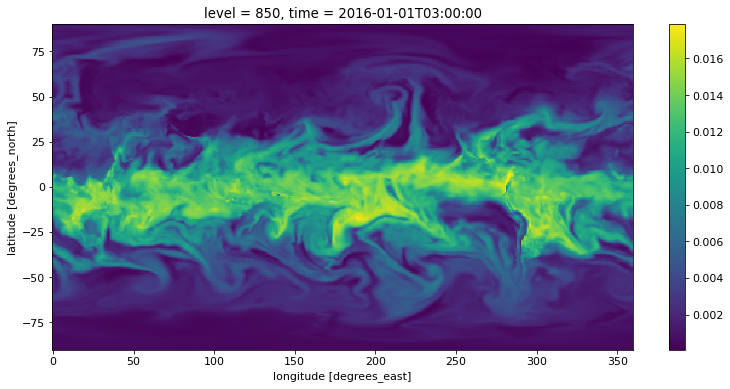

In [282]:
m_r[0,6,:,:].plot()

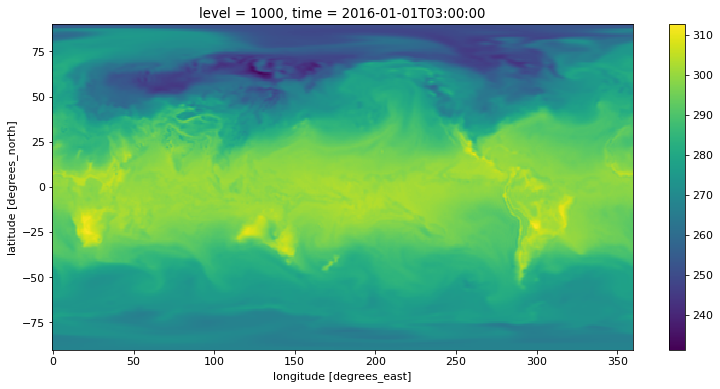

In [283]:
eq_pot_temp[0,:,:,0].plot()

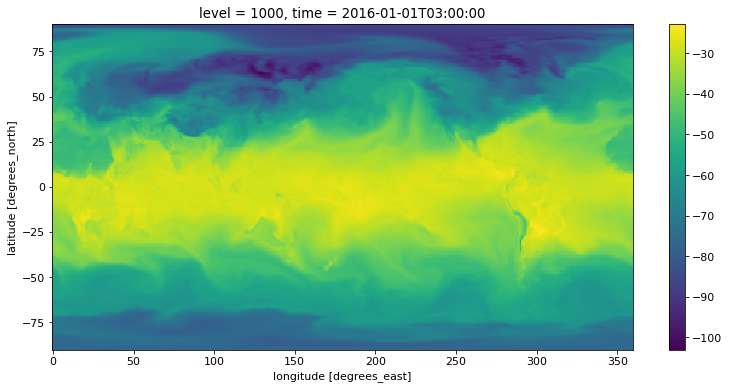

In [280]:
dewpoint[0,0,:,:].plot()

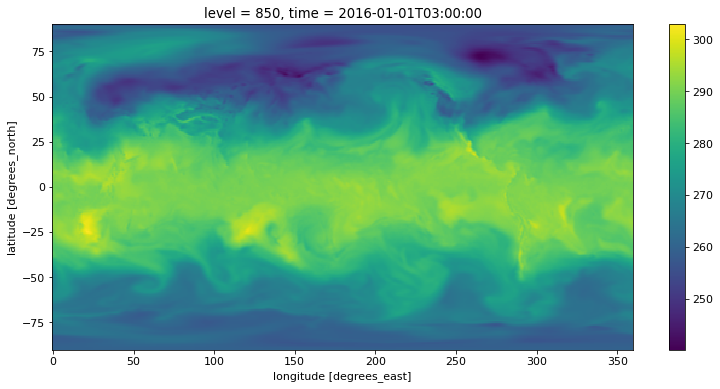

In [278]:
p_tem[0,:,:,6].plot()

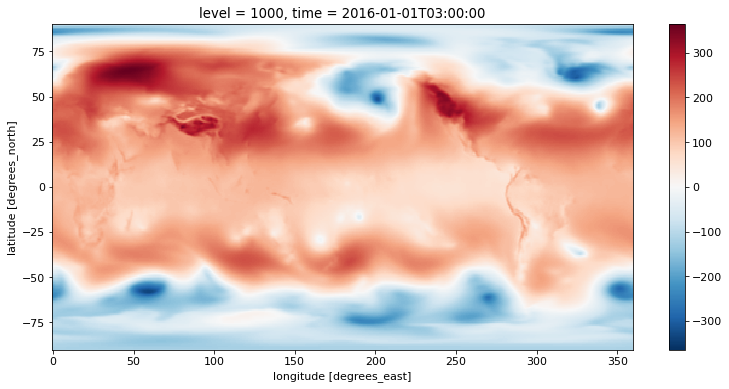

In [275]:
geop_h[0,0,:,:].plot()

# 500 hPa Geopotential Heights, Absolute Vorticity, and Winds


- This example uses example data from the NAM analysis for 12 UTC 31 October 2016 and uses xarray as the main read source with using MetPy to calculate absolute vorticity and wind speed with geographi plotting using Cartopy for a CONUS view of the 500-hPa geopotential heights, absolute vorticity, and wind barbs.

- Import the needed modules.

In [285]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr

In [286]:
ds = xr.open_dataset('NAM_20161031_1200.nc').metpy.parse_cf()
print(ds.coords)

Coordinates:
  * time                  (time) datetime64[ns] 2016-10-31T12:00:00
  * isobaric              (isobaric) float32 50.0 75.0 100.0 ... 975.0 1000.0
  * y                     (y) float32 -832207.3 -820016.4 ... 4373350.0
  * x                     (x) float32 -4223613.0 -4211422.0 ... 3249470.8
    metpy_crs             object Projection: lambert_conformal_conic
  * height_above_ground1  (height_above_ground1) float32 2.0 80.0
  * height_above_ground   (height_above_ground) float32 2.0
  * height_above_ground3  (height_above_ground3) float32 10.0 80.0


In [287]:
#Data Retrieval
#This code retrieves the necessary data from the file and completes some smoothing of the geopotential height and wind fields using the SciPy function gaussian_filter. A nicely formated valid time (vtime) variable is also created.

# Grab lat/lon values (NAM will be 2D)
lats = ds.lat.data
lons = ds.lon.data

# Select and grab 500-hPa geopotential heights and wind components, smooth with gaussian_filter
hght_500 = mpcalc.smooth_n_point(ds.Geopotential_height_isobaric.sel(
    isobaric=500).data[0], 9, 50)
uwnd_500 = mpcalc.smooth_n_point(ds['u-component_of_wind_isobaric'].sel(
    isobaric=500).data[0], 9, 50) * units('m/s')
vwnd_500 = mpcalc.smooth_n_point(ds['v-component_of_wind_isobaric'].sel(
    isobaric=500).data[0], 9, 50) * units('m/s')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

MetPy Absolute Vorticity Calculation
This code first uses MetPy to calcualte the grid deltas (sign aware) to use for derivative calculations with the funtcion lat_lon_grid_deltas() and then calculates absolute_vorticity() using the wind components, grid deltas, and latitude values.

In [288]:
# Calculate grid spacing that is sign aware to use in absolute vorticity calculation
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Calculate absolute vorticity from MetPy function
avor_500 = mpcalc.absolute_vorticity(uwnd_500, vwnd_500, dx, dy, lats * units.degrees)

# Map Creation
- This next set of code creates the plot and draws contours on a Lambert Conformal map centered on -100 E longitude. The main view is over the CONUS with geopotential heights contoured every 60 m and absolute vorticity colorshaded ().


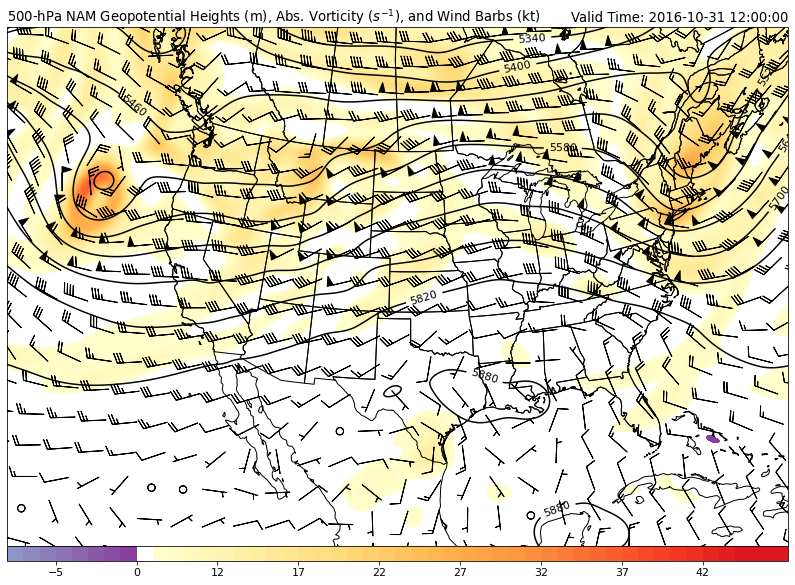

In [289]:
#Map Creation
#This next set of code creates the plot and draws contours on a Lambert Conformal map centered on -100 E longitude. The main view is over the CONUS with geopotential heights contoured every 60 m and absolute vorticity colorshaded ().

# Set up the projection that will be used for plotting
mapcrs = ccrs.LambertConformal(central_longitude=-100, central_latitude=35,
                               standard_parallels=(30, 60))

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()
windcrs = ds.Geopotential_height_isobaric.metpy.cartopy_crs

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Absolute Vorticity colors
# Use two different colormaps from matplotlib and combine into one color set
clevs_500_avor = list(range(-8, 1, 1))+list(range(8, 46, 1))
colors1 = plt.cm.YlOrRd(np.linspace(0, 1, 48))
colors2 = plt.cm.BuPu(np.linspace(0.5, 0.75, 8))
colors = np.vstack((colors2, (1, 1, 1, 1), colors1))

# Plot absolute vorticity values (multiplying by 10^5 to scale appropriately)
cf = ax.contourf(lons, lats, avor_500*1e5, clevs_500_avor, colors=colors, extend='max',
                 transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50, extendrect=True)

# Plot 500-hPa Geopotential Heights in meters
clevs_500_hght = np.arange(0, 8000, 60)
cs = ax.contour(lons, lats, hght_500, clevs_500_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Set up a 2D slice to reduce the number of wind barbs plotted (every 20th)
wind_slice = (slice(None, None, 20), slice(None, None, 20))
xx, yy = np.meshgrid(ds.x.values, ds.y.values)
ax.barbs(xx[wind_slice], yy[wind_slice],
         uwnd_500.to('kt')[wind_slice].m, vwnd_500[wind_slice].to('kt').m,
         pivot='middle', color='black', transform=windcrs)

# Plot two titles, one on right and left side
plt.title('500-hPa NAM Geopotential Heights (m), Abs. Vorticity ($s^{-1}$),'
          ' and Wind Barbs (kt)', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

plt.savefig('500_hPa_Abs_Vorticity.png', dpi=150, bbox_inches='tight')
plt.show()